### Critierion to Judge the Quality of Python Packages:
- Professional Website
- Documentation Quality
- Bug Tracking
- Version Numbering
- Funding Model (How is Development Supported?) 

## Parsing HTML with BeautifulSoup:

- **Goal**: Get the 'Grains' commodities contract list from [barchart](barchart.com/futures/major-commodities)

In [51]:
from bs4 import BeautifulSoup
import requests

url = "https://www.barchart.com/futures/major-commodities"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
page_content = requests.get(url, headers=headers).text

soup = BeautifulSoup(page_content, 'html.parser')

In [52]:
soup.title

<title>Commodities Prices - Barchart.com</title>

In [56]:
content_blocks = soup.find_all(soup.find_all("div", {"class": "barchart-content-block ng-scope", "data-ng-repeat": "(key, item) in data track by $index"}))

for block in content_blocks:
    if any(a.text.lower() == "grains" for a in block.find_all("a")):
        grains_table = block
        break
else:
    raise Exception("Could not locate the Grain commodities table.")

In [57]:
table_grid = grains_table.find_all("div")



## Creating a Basic Webapp with Flask:

In [65]:
import io
import base64

import requests
import bs4
import flask

import PIL.Image
import PIL.ImageOps
import PIL.ImageEnhance

In [62]:
def getstereo(date):
    # get SDO index for date, find all 512x512 171-angstrom images 
    indexreq = requests.get(f'https://sdo.gsfc.nasa.gov/assets/img/browse/{date}')
    soup = bs4.BeautifulSoup(indexreq.content, 'lxml')
    filenames = [link.string for link in soup.pre.find_all('a')
                             if link.string.endswith('512_0171.jpg')]
    
    # get two images across the day
    images = []
    # note integer division in case there's an odd number
    for filename in [filenames[0], filenames[len(filenames)//2]]:
        imagereq = requests.get(f'https://sdo.gsfc.nasa.gov/assets/img/browse/{date}/{filename}')
        images.append(PIL.Image.open(io.BytesIO(imagereq.content)))
    
    # grayscale + colorize the two images
    red  = PIL.ImageOps.colorize(images[0].convert('L'), (0,0,0), (255,0,0))
    cyan = PIL.ImageOps.colorize(images[1].convert('L'), (0,0,0), (0,255,255))

    # blend and adjust brightness
    blend = PIL.Image.blend(red, cyan, 0.5)
    final = PIL.ImageEnhance.Brightness(blend).enhance(2.5)
    
    return final

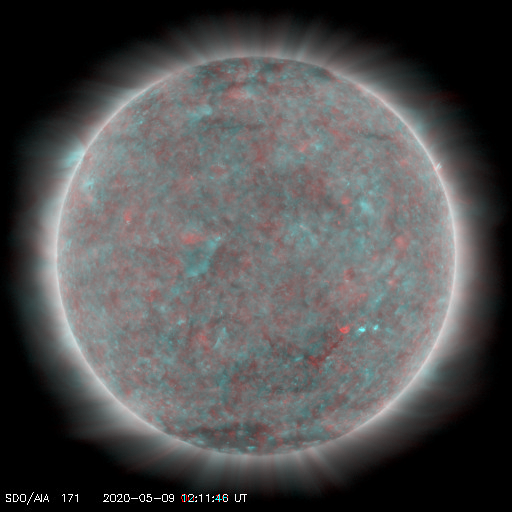

In [75]:
img = getstereo('2020/05/09')
img

In [76]:
# Setup FLask app:

import flask

def run_app():
    app = flask.Flask(__name__)

    @app.route('/')
    def hello_world():
        return flask.Response('<html><body><h1>Use the "/year/month/day" route to get the stereo image for that timestamp.</h1></body></html>')
    
    @app.route('/<year>/<month>/<day>')
    def get_image(year, month, day):
        stereo = getstereo(f'{year}/{month}/{day}')
        
        # Store the fetched image in bytesIO memory so that it can be referenced by the webapp
        buffer = io.BytesIO()
        img.save(buffer, format='PNG')
        b64image = base64.b64encode(buffer.getvalue()).decode('ascii')

        # Build HTML representation of an inline PNG image
        return f'<img src="data:image/png;base64,{b64image}"/>'
    
    app.run(host='0.0.0.0')
    

In [77]:
run_app()

# If running the webapp through jupyter, i + i to interrupt the kernel